# Finding out mean times until spike

In [ ]:
import pandas as pd
import requests
from datetime import timedelta

data = pd.read_csv("../data/la_morgia_data//pump_telegram.csv")

# Filter out events that are not on the Binance exchange platform
binance_events = data[data["exchange"] == "binance"]

# Convert date and hour columns into a single datetime object
binance_events["datetime"] = pd.to_datetime(
    binance_events["date"] + " " + binance_events["hour"]
)


def get_binance_klines(symbol, event_time):
    base_url = "https://api.binance.com/api/v3/klines"

    # Calculate start and end times in milliseconds since the Unix epoch
    start_time = int((event_time - timedelta(minutes=1)).timestamp() * 1000)
    end_time = int((event_time + timedelta(minutes=30)).timestamp() * 1000)

    params = {
        "symbol": symbol,
        "interval": "1m",
        "startTime": start_time,
        "endTime": end_time,
    }
    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        return None


spike_times = []
for index, row in binance_events.iterrows():
    symbol = row["symbol"] + "BTC"  # Using BTC as the trading pair
    klines_data = get_binance_klines(symbol, row["datetime"])

    if klines_data:
        prices = [float(entry[1]) for entry in klines_data[1:]]
        max_price_minute = prices.index(max(prices))
        spike_times.append(max_price_minute + 1)  # +1 because indexing starts from 0

spike_times

In [2]:
# calculate statistics
import numpy as np



def mad(data):
    median_val = np.median(data)


    mad_val = np.median(np.abs(data - median_val))
    return mad_val



def iqr(data):
    q1 = np.percentile(data, 25)


    q3 = np.percentile(data, 75)


    iqr_val = q3 - q1
    return iqr_val



mean_spike_time = np.mean(spike_times)


median_spike_time = np.median(spike_times)


std_dev_spike_time = np.std(spike_times)


mean_absolute_deviation = mad(spike_times)


interquartile_range = iqr(spike_times)



print("Mean spike time: ", mean_spike_time)
print("Median spike time: ", median_spike_time)
print("Std spike time: ", std_dev_spike_time)
print("Mean Absolute Deviation: ", mean_absolute_deviation)
print("Interquartile Range: ", iqr)

Mean spike time:  4.567251461988304
Median spike time:  3.0
Std spike time:  5.382798721405847
Mean Absolute Deviation:  1.0
Interquartile Range:  <function iqr at 0x000002689393E200>


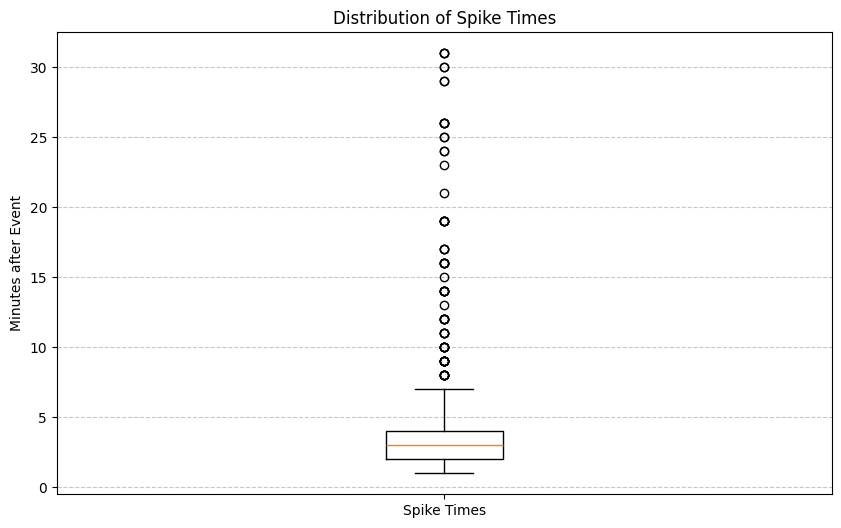

In [3]:
import matplotlib.pyplot as plt

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(spike_times)
plt.title("Distribution of Spike Times")
plt.ylabel("Minutes after Event")
plt.xticks([1], ["Spike Times"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

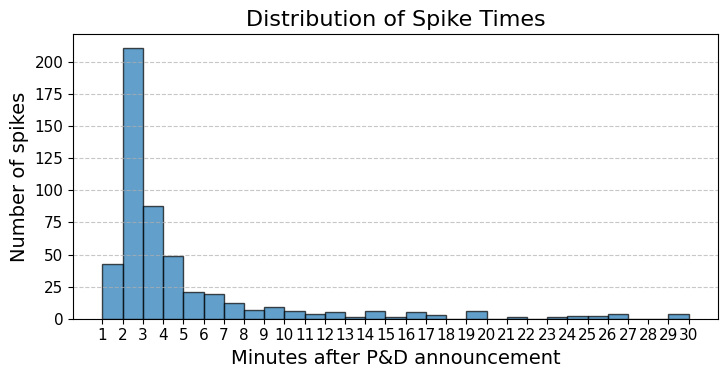

In [4]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11

plt.figure(figsize=(7.5, 4))
plt.hist(spike_times, bins=range(1, 31, 1), edgecolor="black", alpha=0.7)
plt.title("Distribution of Spike Times")
plt.xlabel("Minutes after P&D announcement")
plt.ylabel("Number of spikes")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(range(1, 31, 1))
plt.tight_layout()
plt.savefig("./spike_times.png")
plt.show()